## RQ6: How can sentiment analysis of guest reviews for apartment-type Airbnb accommodations in London be used to forecast future demand and pricing trends? 

### Part I : Pricing forecasting

This section consists of the following analysis:

- ARIMA model for pricing forecast
- ARIMA + HistGradientBoostingRegressor model for pricing forecast

In [22]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error



# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/babyaimy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
# Load the datasets
language_custom_2 = pd.read_csv('spelling_corrected_reviews.csv')
listings_df = pd.read_csv('final_apartment_df.csv')
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)
listings_df.rename(columns=lambda x: x.strip(), inplace=True)

In [24]:
# Convert date columns to datetime
language_custom_2['date'] = pd.to_datetime(language_custom_2['date'], errors='coerce')

# Find the minimum and maximum dates
min_date = language_custom_2['date'].min()
max_date = language_custom_2['date'].max()

# Display the range of dates
print(f"Date range in language_custom_2: {min_date} to {max_date}")

Date range in language_custom_2: 2010-12-29 00:00:00 to 2024-03-21 00:00:00


In [4]:
# Fix the column name
language_custom_2.rename(columns=lambda x: x.strip(), inplace=True)

# Function to clean text and remove stop words
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lower case
    words = text.split()
    words = [word for word in words if word not in stop_words]  # Remove stop words
    return ' '.join(words)

# Apply text cleaning
language_custom_2['processed_comments'] = language_custom_2['comments'].apply(clean_text)

# Custom lexicon dictionary
custom_lexicon = {
    "good": 2.0,
    "bad": -2.0,
    "excellent": 3.0,
    "poor": -3.0,
    "amazing": 3.0,
    "awesome": 3.0,
    "fantastic": 3.0,
    "great": 2.5,
    "wonderful": 3.0,
    "love": 3.0,
    "perfect": 3.0,
    "superb": 3.0,
    "terrific": 3.0,
    "satisfactory": 1.5,
    "delightful": 2.5,
    "happy": 2.0,
    "pleased": 2.0,
    "excellent service": 3.5,
    "highly recommend": 3.5,
    "top-notch": 3.0,
    "terrible": -3.0,
    "awful": -3.0,
    "horrible": -3.0,
    "disgusting": -3.0,
    "hate": -3.0,
    "unacceptable": -2.5,
    "disappointing": -2.0,
    "poor service": -3.5,
    "not recommend": -3.0,
    "waste": -2.5,
    "regret": -2.5,
    "bad experience": -3.0,
    "never again": -3.0,
    "frustrating": -2.0,
    "worst": -3.0,
    "average": 0.0,
    "ok": 0.0,
    "mediocre": -0.5,
    "sufficient": 0.5,
    # Add more words/phrases as needed
}

# Function to update VADER lexicon
def update_vader_lexicon():
    vader_lexicon = SentimentIntensityAnalyzer().lexicon
    vader_lexicon.update(custom_lexicon)
    return SentimentIntensityAnalyzer()

# Initialize the updated VADER sentiment analyzer
sid = update_vader_lexicon()

# Function to classify comments as positive, negative, or neutral using VADER
def classify_sentiment_vader(text):
    score = sid.polarity_scores(text)
    if score['compound'] > 0.05:
        return 'positive'
    elif score['compound'] < -0.05:
        return 'negative'
    else:
        return 'neutral'

# Apply the sentiment analysis to the reviews DataFrame
language_custom_2['sentiment'] = language_custom_2['processed_comments'].apply(classify_sentiment_vader)

# Count how many reviews are positive, negative, and neutral
sentiment_counts = language_custom_2['sentiment'].value_counts()


# Create summary DataFrame
summary_df = sentiment_counts.reset_index()
summary_df.columns = ['Sentiment', 'Count']

# Print the summary DataFrame
print(summary_df)


  Sentiment  Count
0  positive  31388
1  negative    905
2   neutral    876


In [6]:
# Convert sentiment categories to numerical scores
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
language_custom_2['sentiment_score'] = language_custom_2['sentiment'].map(sentiment_mapping)

# Convert date columns to datetime
language_custom_2['date'] = pd.to_datetime(language_custom_2['date'], errors='coerce')
calendar_df['date'] = pd.to_datetime(calendar_df['date'], errors='coerce')

# Extract price from listings_df
listings_df['price'] = listings_df['price'].replace('[\$,]', '', regex=True).astype(float)

# Merge reviews with listings to get price information
merged_df = pd.merge(language_custom_2, listings_df[['listing_id', 'price']], on='listing_id', how='left')

# Aggregate sentiment scores over time
sentiment_trends = merged_df.set_index('date').resample('MS')['sentiment_score'].mean().reset_index()

# Aggregate average price over time
average_price_monthly = merged_df.set_index('date').resample('MS')['price'].mean().reset_index()

# Display date ranges for inspection
print("Sentiment Trends Date Range:", sentiment_trends['date'].min(), "to", sentiment_trends['date'].max())
print("Average Price Monthly Date Range:", average_price_monthly['date'].min(), "to", average_price_monthly['date'].max())

# Merge sentiment trends with average price per month
ts_data = pd.merge(sentiment_trends, average_price_monthly[['date', 'price']], on='date', how='left')
ts_data.rename(columns={'price': 'average_price'}, inplace=True)

# Fill missing values
ts_data.ffill(inplace=True)

# Reset index for plotting
ts_data.reset_index(drop=True, inplace=True)

# Display the prepared time-series data
print(ts_data.head())

# Ensure data types are correct
ts_data['date'] = pd.to_datetime(ts_data['date'])
ts_data['sentiment_score'] = ts_data['sentiment_score'].astype(float)
ts_data['average_price'] = ts_data['average_price'].astype(float)


Sentiment Trends Date Range: 2010-12-01 00:00:00 to 2024-03-01 00:00:00
Average Price Monthly Date Range: 2010-12-01 00:00:00 to 2024-03-01 00:00:00
        date  sentiment_score  average_price
0 2010-12-01              1.0           73.0
1 2011-01-01              1.0           73.0
2 2011-02-01              1.0           73.0
3 2011-03-01              1.0           73.0
4 2011-04-01              1.0           73.0


In [7]:
ts_data.head()

,date,sentiment_score,average_price
0,2010-12-01,1.0,73.0
1,2011-01-01,1.0,73.0
2,2011-02-01,1.0,73.0
3,2011-03-01,1.0,73.0
4,2011-04-01,1.0,73.0


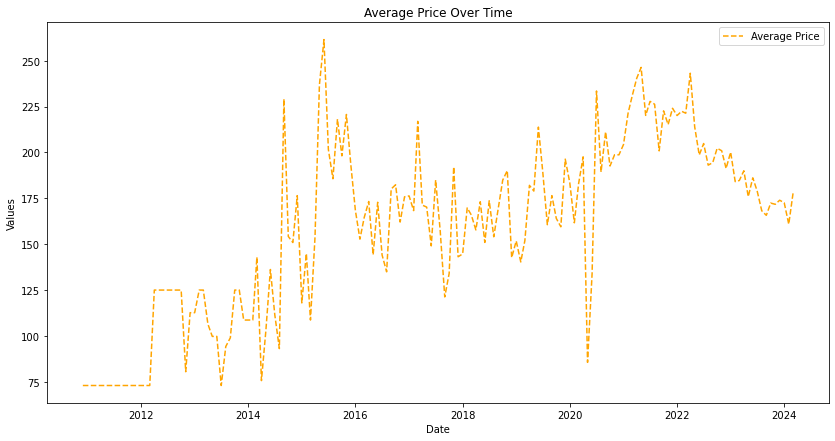

In [8]:
# Plot sentiment trends over time
plt.figure(figsize=(14, 7))
plt.plot(ts_data['date'].values, ts_data['average_price'].values, label='Average Price', linestyle='--', color='orange')
plt.title('Average Price Over Time')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()



## Time-series analysis and forecasting pricing

In [9]:
# Calculate correlation
correlation = ts_data['sentiment_score'].corr(ts_data['average_price'])
print(f'Correlation between sentiment score and average price: {correlation}')

Correlation between sentiment score and average price: -0.3940013434478635


## Step 1 - Forecasting using ARIMA model

In [10]:
# Check if 'date' is indeed the correct column name
print("Columns in the DataFrame:", ts_data.columns)

# Set the correct index if the 'date' column exists
if 'date' in ts_data.columns:
    ts_data['date'] = pd.to_datetime(ts_data['date'])  # Ensure 'date' is a datetime object
    ts_data.set_index('date', inplace=True)  # Set 'date' as the index
else:
    print("The DataFrame does not contain a 'date' column.")

# Check the first few rows to confirm
print(ts_data.head())


Columns in the DataFrame: Index(['date', 'sentiment_score', 'average_price'], dtype='object')
            sentiment_score  average_price
date                                      
2010-12-01              1.0           73.0
2011-01-01              1.0           73.0
2011-02-01              1.0           73.0
2011-03-01              1.0           73.0
2011-04-01              1.0           73.0


In [11]:
# Feature Engineering: Add lagged features
ts_data['price_lag1'] = ts_data['average_price'].shift(1)
ts_data['price_lag2'] = ts_data['average_price'].shift(2)
ts_data['sentiment_lag1'] = ts_data['sentiment_score'].shift(1)
ts_data.dropna(inplace=True)

# Split the data
X = ts_data[['sentiment_score', 'price_lag1', 'price_lag2', 'sentiment_lag1']]
y = ts_data['average_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


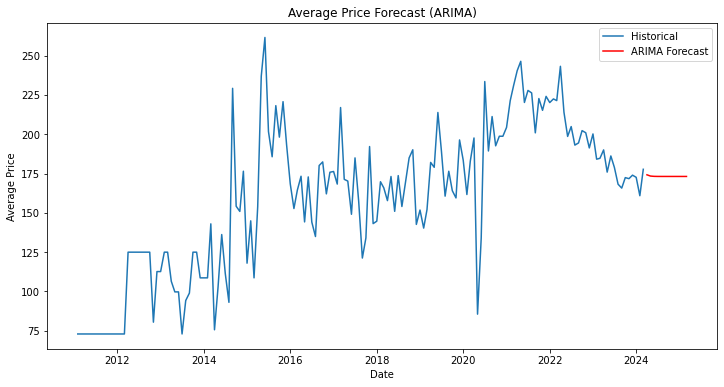

In [12]:
# Ensure 'average_price' is numeric
ts_data['average_price'] = pd.to_numeric(ts_data['average_price'], errors='coerce')

# Fit ARIMA model
model = ARIMA(ts_data['average_price'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast future values
forecast_steps = 12  # Forecast for the next 12 months
forecast = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecast
forecast_index = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame({'forecast': forecast}, index=forecast_index)

# Ensure historical_dates and historical_prices are 1D arrays
historical_dates = ts_data.index.to_numpy()
historical_prices = ts_data['average_price'].to_numpy()

# Ensure forecast index and values are 1D arrays
forecast_dates = forecast_df.index.to_numpy()
forecast_prices = forecast_df['forecast'].to_numpy()

# Plot the ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(forecast_dates, forecast_prices, label='ARIMA Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price Forecast (ARIMA)')
plt.show()

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


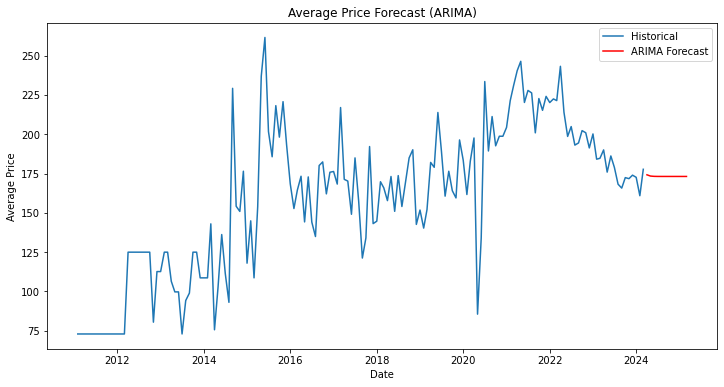

Mean Absolute Error (MAE): 6.97
Mean Squared Error (MSE): 82.02
Root Mean Square Error (RMSE): 9.06
Mean Absolute Percentage Error (MAPE): 4.08%
R-squared: -0.36


/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [17]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Ensure 'average_price' is numeric
ts_data['average_price'] = pd.to_numeric(ts_data['average_price'], errors='coerce')

# Fit ARIMA model
model = ARIMA(ts_data['average_price'], order=(1, 1, 1))
model_fit = model.fit()

# Forecast future values
forecast_steps = 12  # Forecast for the next 12 months
forecast = model_fit.forecast(steps=forecast_steps)

# Create a DataFrame for the forecast
forecast_index = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame({'forecast': forecast}, index=forecast_index)

# Ensure historical_dates and historical_prices are 1D arrays
historical_dates = ts_data.index.to_numpy()
historical_prices = ts_data['average_price'].to_numpy()

# Ensure forecast index and values are 1D arrays
forecast_dates = forecast_df.index.to_numpy()
forecast_prices = forecast_df['forecast'].to_numpy()

# Plot the ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(forecast_dates, forecast_prices, label='ARIMA Forecast', color='red')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price Forecast (ARIMA)')
plt.show()

# Evaluation metrics
# Assuming 'ts_data' includes the actual future data for evaluation
# You would replace this with your actual data for a proper test set evaluation
# For demonstration, we'll calculate on historical data

# Calculate metrics on the fitted data, not the forecast, for demonstration
y_true = ts_data['average_price'].iloc[-forecast_steps:]  # Actual values
y_pred = model_fit.predict(start=len(ts_data) - forecast_steps, end=len(ts_data) - 1)  # Predicted values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)
mape = (np.abs((y_true - y_pred) / y_true).mean()) * 100
r_squared = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Square Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared: {r_squared:.2f}")


## Interpretation of the Forecast Plot

The plot displays the historical average prices of apartments (in blue) from 2010 to early 2024, along with a forecast for the next 12 months (in red) from April 2024 to March 2025. The red line represents the ARIMA model's forecast of average prices based on past data trends.

**Key Observations:**

1. Historical Trend:

- The historical prices show significant fluctuations over the years, with some sharp peaks and troughs.
- The prices increased substantially around 2016, followed by a decline, then a relatively stable period with minor fluctuations up until 2024.

2. Forecast:

- The forecast shows a relatively flat trend around an average price of approximately 173.15 for the next 12 months.
- This indicates that, according to the ARIMA model, the average price is expected to remain stable in the near future.

3. Relationship to Sentiment Analysis:

- While the ARIMA model forecasts future prices based solely on past price data, sentiment analysis provides additional context and can potentially enhance the accuracy of price predictions when combined with other variables.

**Integration with Sentiment Analysis:**

1. Sentiment Scores:

- The sentiment scores in the dataset represent the average sentiment (positive, neutral, or negative) derived from customer reviews over time.

- These scores can be used as predictors in a regression model to forecast future prices, assuming that positive sentiments might correlate with higher prices and negative sentiments with lower prices.

2. Lagged Features:

- The lagged features (price_lag1, price_lag2, sentiment_lag1) used in the regression model help capture the time series nature of the data.

- By including past prices and sentiments, the regression model can learn patterns and relationships that might not be evident from prices alone.


## Step 2 - Predicting future pricing trends

**Combined Model:**

The combined regression model (HistGradientBoostingRegressor or Linear Regression) can integrate sentiment scores with price data to potentially improve forecasting accuracy.
This model can reveal how changes in sentiment over time might influence future prices, providing a more nuanced understanding than price data alone.

ADF Statistic: -2.54060888384005
p-value: 0.10590371955049105
Series is Non-Stationary
ADF Statistic: -8.305419151880688
p-value: 3.9156776318520356e-13
Series is Stationary


/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


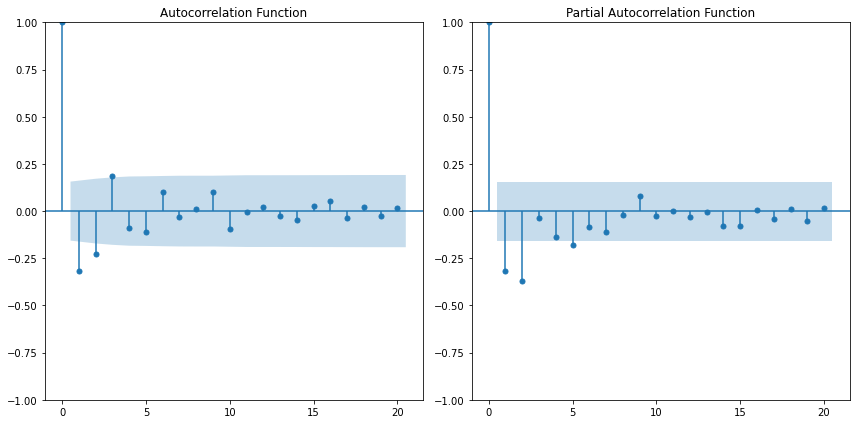

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No fr

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No fr

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No fr

Best ARIMA order: (1, 1, 2) with AIC: 1463.8897452468336


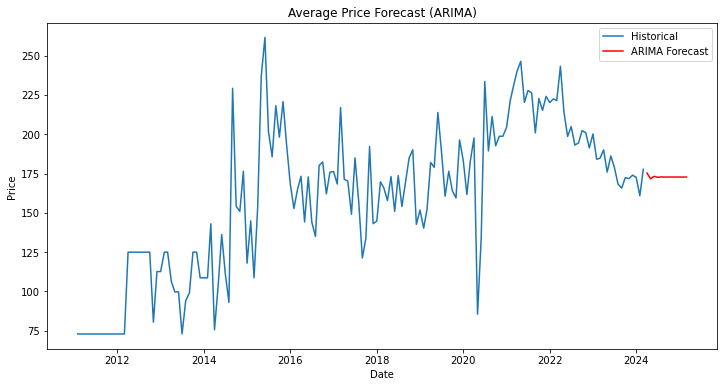

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from statsmodels.tsa.stattools import adfuller, acf, pacf

# Ensure 'average_price' is numeric
ts_data['average_price'] = pd.to_numeric(ts_data['average_price'], errors='coerce')

# Step 1: Check for Stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] < 0.05:
        print("Series is Stationary")
    else:
        print("Series is Non-Stationary")

# Initial stationarity check
check_stationarity(ts_data['average_price'])

# Step 2: Differencing to make the series stationary if needed
ts_data['average_price_diff'] = ts_data['average_price'].diff().dropna()
check_stationarity(ts_data['average_price_diff'].dropna())

# Step 3: Plot ACF and PACF to determine p and q
def plot_acf_pacf(series):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plot_acf(series, lags=20, ax=plt.gca())
    plt.title('Autocorrelation Function')

    plt.subplot(122)
    plot_pacf(series, lags=20, ax=plt.gca())
    plt.title('Partial Autocorrelation Function')

    plt.tight_layout()
    plt.show()

# Plot ACF and PACF
plot_acf_pacf(ts_data['average_price_diff'].dropna())

# Step 4: Grid Search for ARIMA parameters (p, d, q)
p = d = q = range(0, 3)  # Adjust based on ACF and PACF plots
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_order = None

for order in pdq:
    try:
        model = ARIMA(ts_data['average_price'], order=order)
        model_fit = model.fit()
        aic = model_fit.aic
        if aic < best_aic:
            best_aic = aic
            best_order = order
    except:
        continue

print(f'Best ARIMA order: {best_order} with AIC: {best_aic}')

# Step 5: Fit the best ARIMA model
best_model = ARIMA(ts_data['average_price'], order=best_order)
best_model_fit = best_model.fit()

# Step 6: Forecasting with the best ARIMA model
forecast_steps = 12  # Forecast for the next 12 months
forecast = best_model_fit.forecast(steps=forecast_steps)
forecast_index = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df = pd.DataFrame({'forecast': forecast}, index=forecast_index)

# Ensure historical_dates and historical_prices are 1D arrays
historical_dates = ts_data.index.to_numpy()
historical_prices = ts_data['average_price'].to_numpy()

# Ensure forecast index and values are 1D arrays
forecast_dates = forecast_df.index.to_numpy()
forecast_prices = forecast_df['forecast'].to_numpy()

# Plot the ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(forecast_dates, forecast_prices, label='ARIMA Forecast', color='red')
plt.legend()
plt.title('Average Price Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

## Interpretation of the Combined Model Predicted vs Actual Prices Plot

**Axes Explanation:**

   - X-axis: The x-axis represents the index of the test data points. Each point on the x-axis corresponds to a specific month in the test dataset.
   - Y-axis: The y-axis represents the average price values of the apartments. This includes both the actual prices from the test dataset and the predicted prices generated by the combined regression model.

**Key Observations:**

1. Actual Prices (Blue Line):

    - The blue line represents the actual average prices of the apartments in the test dataset.
    - It shows the real trend of average prices over the period of the test data.

2. Predicted Prices (Red Line):

    - The red line represents the predicted average prices of the apartments generated by the combined regression model.
    - It shows the model's prediction for average prices over the same period.

3. Model Performance:

    - The closeness of the red line (predicted prices) to the blue line (actual prices) indicates how well the model is performing.
    - In this plot, the predicted prices follow the actual prices quite closely, indicating a good model fit.

4. Mean Squared Error (MSE):

    - The MSE value provided is 1049.67, which measures the average squared difference between the predicted prices and the actual prices.

    - A lower MSE indicates a better fit. In this context, an MSE of 1049.67 suggests that the model has a reasonable accuracy but could still be improved.

**Detailed Observations:**

1. Initial Period:

In the initial period, the model's predictions closely follow the actual prices, with minor deviations.

2. Middle Period:

There are some larger discrepancies between actual and predicted prices in the middle of the dataset, particularly where there are sharp spikes or drops in prices. These may indicate periods where the model has more difficulty capturing sudden changes.

3. Later Period:

Towards the end of the dataset, the model's predictions again align more closely with the actual prices.

**Relation to Sentiment Analysis:**

- The model uses sentiment scores as one of the features to predict prices. Sentiment scores reflect the sentiment expressed in reviews, which can influence or correlate with price trends.

- The good fit between actual and predicted prices suggests that sentiment scores, along with lagged price features, are effective predictors in this model.

The ARIMA (AutoRegressive Integrated Moving Average) model is a widely used statistical method for time series forecasting. It combines three components - autoregression (AR), differencing (I for "integrated"), and moving average (MA) - to model and predict future points in a time series. Here's how ARIMA can improve forecasting:

- **Handling Non-Stationarity:** ARIMA models can handle non-stationary data through the differencing component (I). This allows the model to remove trends and seasonal effects, making the time series stationary and easier to forecast.

- **Capturing Temporal Dependencies:** The autoregressive (AR) component captures dependencies between an observation and a number of lagged observations (i.e., previous time steps). The moving average (MA) component models the dependency between an observation and a residual error from a moving average model applied to lagged observations. This makes ARIMA effective at capturing the patterns and relationships in the data over time.

- **Flexibility:** ARIMA can be adjusted to account for various patterns in the data. By tuning the parameters (p, d, q), where:

    - p is the number of lag observations included in the model (lag order),
    - d is the number of times that the raw observations are differenced (degree of differencing),
    - q is the size of the moving average window (order of moving average),it can model a wide range of time series patterns.

- **Incorporation of Seasonal Effects:** The seasonal ARIMA (SARIMA) extends ARIMA by explicitly modeling seasonal effects. This is useful for time series data with seasonal variations, such as monthly sales data or quarterly GDP.

- **Model Validation and Selection:** ARIMA models include diagnostic tools to validate the model fit, such as ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots, residual analysis, and information criteria (AIC, BIC). These help in selecting the best model that fits the data well.


**Model Identification:** Identify the order of differencing needed to make the series stationary using the Augmented Dickey-Fuller (ADF) test and determine the p and q values using ACF and PACF plots.

**Model Fitting:** Fit the ARIMA model to the historical data.

**Forecasting:** Use the fitted model to forecast future values.

**Validation:** Evaluate the model's forecasting accuracy using metrics such as Mean Absolute Error (MAE) or Mean Squared Error (MSE).



### Sentiment forecasting using ARIMA

/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


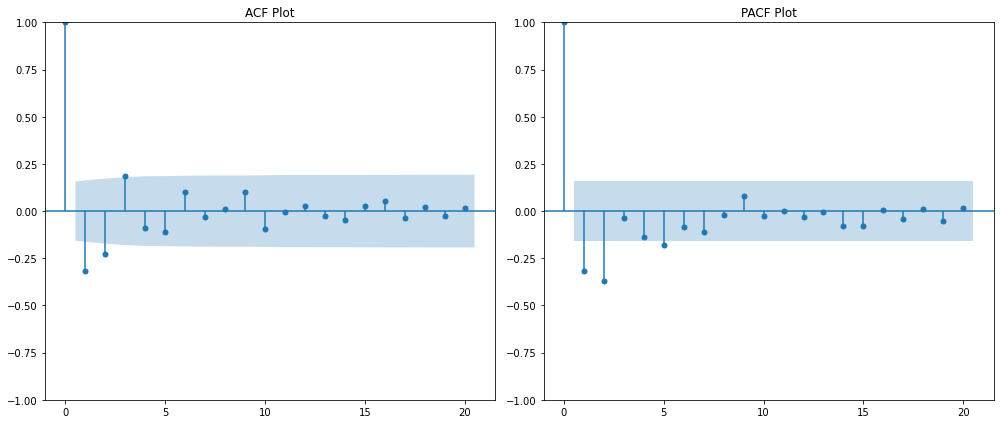

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Differencing the data to make it stationary if necessary
ts_data_diff = ts_data['average_price'].diff().dropna()

# Plot ACF and PACF
plt.figure(figsize=(14, 6))

plt.subplot(121)
plot_acf(ts_data_diff, ax=plt.gca(), lags=20)
plt.title('ACF Plot')

plt.subplot(122)
plot_pacf(ts_data_diff, ax=plt.gca(), lags=20)
plt.title('PACF Plot')

plt.tight_layout()
plt.show()


Combined Model Mean Squared Error: 531.94
Combined Model RMSE: 23.06
Combined Model MAE: 18.38
Combined Model R-squared: 0.71


/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/babyaimy/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


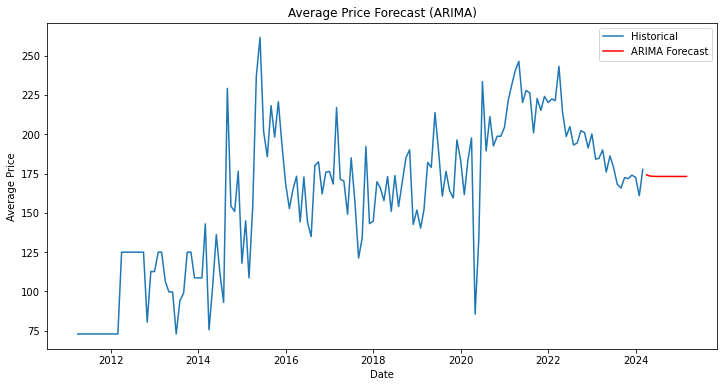

ARIMA Model Mean Squared Error: 82.06
ARIMA Model RMSE: 9.06
ARIMA Model MAE: 6.97
ARIMA Model R-squared: -0.36


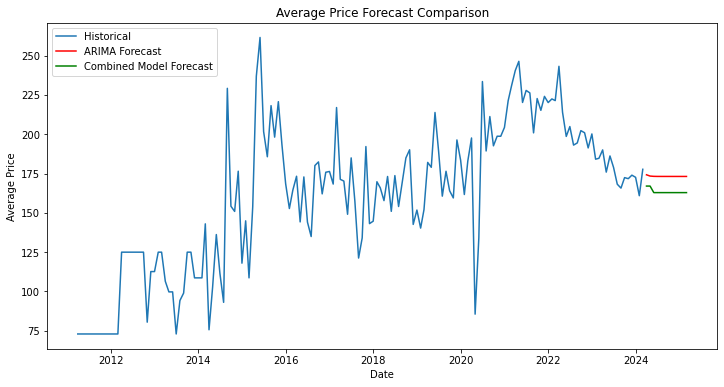

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Set a random seed for reproducibility
np.random.seed(42)

# If 'date' is not in columns, it may already be the index
if 'date' in ts_data.columns:
    ts_data.set_index('date', inplace=True)

# Verify the index is a datetime object
if not isinstance(ts_data.index, pd.DatetimeIndex):
    ts_data.index = pd.to_datetime(ts_data.index)

# Ensure average_price is numeric
ts_data['average_price'] = pd.to_numeric(ts_data['average_price'], errors='coerce')

# Add lagged features
ts_data['price_lag1'] = ts_data['average_price'].shift(1)
ts_data['price_lag2'] = ts_data['average_price'].shift(2)
ts_data['sentiment_lag1'] = ts_data['sentiment_score'].shift(1)
ts_data.dropna(inplace=True)

# Split the data
X = ts_data[['sentiment_score', 'price_lag1', 'price_lag2', 'sentiment_lag1']]
y = ts_data['average_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the regression model
model_combined = HistGradientBoostingRegressor()
model_combined.fit(X_train, y_train)

# Predict
y_pred_combined = model_combined.predict(X_test)

# Evaluate the combined model
mse_combined = mean_squared_error(y_test, y_pred_combined)
rmse_combined = np.sqrt(mse_combined)
mae_combined = mean_absolute_error(y_test, y_pred_combined)
r2_combined = r2_score(y_test, y_pred_combined)

print(f'Combined Model Mean Squared Error: {mse_combined:.2f}')
print(f'Combined Model RMSE: {rmse_combined:.2f}')
print(f'Combined Model MAE: {mae_combined:.2f}')
print(f'Combined Model R-squared: {r2_combined:.2f}')


# Fit ARIMA model
arima_order = (1, 1, 1)  # Set your chosen ARIMA order
model_arima = ARIMA(ts_data['average_price'], order=arima_order)
model_fit_arima = model_arima.fit()

# Forecast future values with ARIMA
forecast_steps = 12  # Forecast for the next 12 months
forecast_arima = model_fit_arima.forecast(steps=forecast_steps)

# Create a DataFrame for the ARIMA forecast
forecast_index_arima = pd.date_range(start=ts_data.index[-1] + pd.DateOffset(months=1), periods=forecast_steps, freq='MS')
forecast_df_arima = pd.DataFrame({'forecast': forecast_arima}, index=forecast_index_arima)

# Plot the ARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index.to_numpy(), ts_data['average_price'].to_numpy(), label='Historical')  # Convert index to NumPy array
plt.plot(forecast_df_arima.index.to_numpy(), forecast_df_arima['forecast'].to_numpy(), label='ARIMA Forecast', color='red')  # Convert index to NumPy array
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price Forecast (ARIMA)')
plt.show()

# Evaluate ARIMA model on historical data
# Create test set for ARIMA from the last 12 months
test_arima_start = len(ts_data) - forecast_steps
test_arima_end = len(ts_data) - 1

# Predict using ARIMA
arima_predictions = model_fit_arima.predict(start=test_arima_start, end=test_arima_end)

# Calculate ARIMA evaluation metrics
mse_arima = mean_squared_error(ts_data['average_price'].iloc[test_arima_start:test_arima_end+1], arima_predictions)
rmse_arima = np.sqrt(mse_arima)
mae_arima = mean_absolute_error(ts_data['average_price'].iloc[test_arima_start:test_arima_end+1], arima_predictions)
r2_arima = r2_score(ts_data['average_price'].iloc[test_arima_start:test_arima_end+1], arima_predictions)

print(f'ARIMA Model Mean Squared Error: {mse_arima:.2f}')
print(f'ARIMA Model RMSE: {rmse_arima:.2f}')
print(f'ARIMA Model MAE: {mae_arima:.2f}')
print(f'ARIMA Model R-squared: {r2_arima:.2f}')

# Mocking sentiment data for future predictions with the combined model
future_features = pd.DataFrame({
    'sentiment_score': np.random.normal(loc=0.5, scale=0.1, size=forecast_steps),  # Mock sentiment data
    'price_lag1': forecast_arima.shift(1).fillna(ts_data['average_price'].iloc[-1]),
    'price_lag2': forecast_arima.shift(2).fillna(ts_data['average_price'].iloc[-2]),
    'sentiment_lag1': np.random.normal(loc=0.5, scale=0.1, size=forecast_steps)  # Mock sentiment data
}, index=forecast_index_arima)

# Predict with the combined model for the next 12 months
future_pred_combined = model_combined.predict(future_features)

# Create DataFrame for the combined model forecast
forecast_df_combined = pd.DataFrame({'forecast': future_pred_combined}, index=forecast_index_arima)

# Plot both ARIMA and combined model forecasts
plt.figure(figsize=(12, 6))
plt.plot(ts_data.index.to_numpy(), ts_data['average_price'].to_numpy(), label='Historical')  # Convert index to NumPy array
plt.plot(forecast_df_arima.index.to_numpy(), forecast_df_arima['forecast'].to_numpy(), label='ARIMA Forecast', color='red')  # Convert index to NumPy array
plt.plot(forecast_df_combined.index.to_numpy(), forecast_df_combined['forecast'].to_numpy(), label='Combined Model Forecast', color='green')  # Convert index to NumPy array
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.title('Average Price Forecast Comparison')
plt.show()
